In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from heisenberg_graph import (
    extract_probs,
)

In [4]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [5]:
# Load parameters
CURRENT_TIME = "2024-11-30T15:46Z"
path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

for key, value in params_object.items():
    print(f"{key}: {value}")

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

graphs: [<networkx.classes.graph.Graph object at 0x7f65d034bb90>, <networkx.classes.graph.Graph object at 0x7f65d0350450>, <networkx.classes.graph.Graph object at 0x7f65d0350a10>, <networkx.classes.graph.Graph object at 0x7f65d0350fd0>, <networkx.classes.graph.Graph object at 0x7f65d0351590>, <networkx.classes.graph.Graph object at 0x7f65d0351b50>, <networkx.classes.graph.Graph object at 0x7f65d0352110>, <networkx.classes.graph.Graph object at 0x7f65d03526d0>, <networkx.classes.graph.Graph object at 0x7f65d0352c90>, <networkx.classes.graph.Graph object at 0x7f65d0353250>, <networkx.classes.graph.Graph object at 0x7f65d0353810>, <networkx.classes.graph.Graph object at 0x7f65d0353dd0>, <networkx.classes.graph.Graph object at 0x7f65d035c3d0>, <networkx.classes.graph.Graph object at 0x7f65d035c990>, <networkx.classes.graph.Graph object at 0x7f65d035cf50>, <networkx.classes.graph.Graph object at 0x7f65d035d510>, <networkx.classes.graph.Graph object at 0x7f65d035dad0>, <networkx.classes.grap

## Plot probability

In [6]:
# Load the data as a json file
with open(f"{path}/probs_phase0_exact.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path}/probs_phase1_exact.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path}/probs_phase2_exact.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path}/probs_phase3_exact.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [7]:
with open(f"{path}/probs_phase0_sim.json", "r") as f:
    probs_phase0_sim = json.load(f)
with open(f"{path}/probs_phase1_sim.json", "r") as f:
    probs_phase1_sim = json.load(f)
with open(f"{path}/probs_phase2_sim.json", "r") as f:
    probs_phase2_sim = json.load(f)
with open(f"{path}/probs_phase3_sim.json", "r") as f:
    probs_phase3_sim = json.load(f)

In [8]:
with open(f"{path}/probs_phase0_sim_noisy.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path}/probs_phase1_sim_noisy.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path}/probs_phase2_sim_noisy.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path}/probs_phase3_sim_noisy.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/2024-11-30T12:09Z/probs_phase0_sim_noisy.json'

In [ ]:
with open(f"{path}/probs_phase0_nmit.json", "r") as f:
    probs_phase0_nmit = json.load(f)
with open(f"{path}/probs_phase1_nmit.json", "r") as f:
    probs_phase1_nmit = json.load(f)
with open(f"{path}/probs_phase2_nmit.json", "r") as f:
    probs_phase2_nmit = json.load(f)
with open(f"{path}/probs_phase3_nmit.json", "r") as f:
    probs_phase3_nmit = json.load(f)

with open(f"{path}/probs_phase0_mit.json", "r") as f:
    probs_phase0_mit = json.load(f)
with open(f"{path}/probs_phase1_mit.json", "r") as f:
    probs_phase1_mit = json.load(f)
with open(f"{path}/probs_phase2_mit.json", "r") as f:
    probs_phase2_mit = json.load(f)
with open(f"{path}/probs_phase3_mit.json", "r") as f:
    probs_phase3_mit = json.load(f)

In [8]:
with open(f"{path}/successful_job_ids_and_samples.json", "r") as f:
    successful_job_ids_and_samples = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './data/2024-11-30T13:39Z/successful_job_ids_and_samples.json'

In [8]:
# For debugging
dummy_successful_job_ids_and_samples = {}
for i in range(n_samples):
    dummy_successful_job_ids_and_samples[f"sample{i}"] = None

successful_job_ids_and_samples = dummy_successful_job_ids_and_samples

In [9]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_job_ids_and_samples.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_job_ids_and_samples.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_job_ids_and_samples.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_job_ids_and_samples.keys()
)

In [10]:
probs_phase0_sim_extracted = extract_probs(
    probs_phase0_sim, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_extracted = extract_probs(
    probs_phase1_sim, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_extracted = extract_probs(
    probs_phase2_sim, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_extracted = extract_probs(
    probs_phase3_sim, successful_job_ids_and_samples.keys()
)

In [ ]:
probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_job_ids_and_samples.keys()
)

In [ ]:
probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_job_ids_and_samples.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_job_ids_and_samples.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_job_ids_and_samples.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_job_ids_and_samples.keys()
)

probs_phase0_mit_extracted = extract_probs(
    probs_phase0_mit, successful_job_ids_and_samples.keys()
)
probs_phase1_mit_extracted = extract_probs(
    probs_phase1_mit, successful_job_ids_and_samples.keys()
)
probs_phase2_mit_extracted = extract_probs(
    probs_phase2_mit, successful_job_ids_and_samples.keys()
)
probs_phase3_mit_extracted = extract_probs(
    probs_phase3_mit, successful_job_ids_and_samples.keys()
)

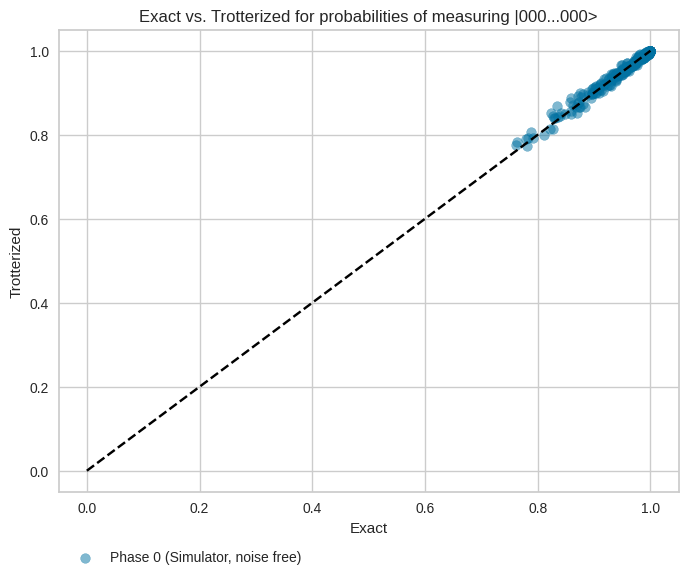

In [11]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_sim_noisy_extracted,
#     label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_nmit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase0_exact_extracted,
#     probs_phase0_mit_extracted,
#     label=f"Phase 0 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

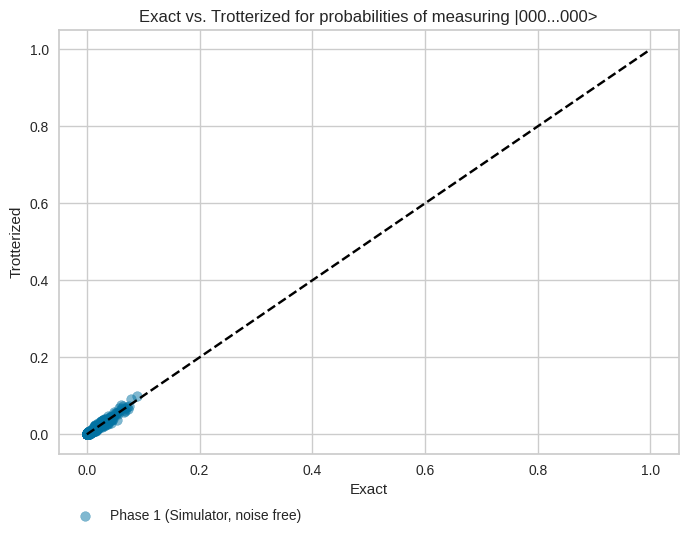

In [12]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_sim_noisy_extracted,
#     label=f"Phase 1 (Simulator, noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_nmit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase1_exact_extracted,
#     probs_phase1_mit_extracted,
#     label=f"Phase 1 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

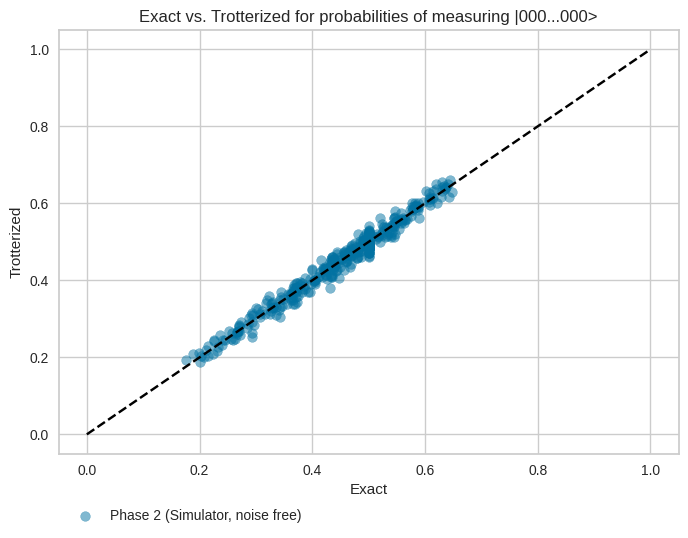

In [13]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_sim_noisy_extracted,
#     label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_nmit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase2_exact_extracted,
#     probs_phase2_mit_extracted,
#     label=f"Phase 2 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

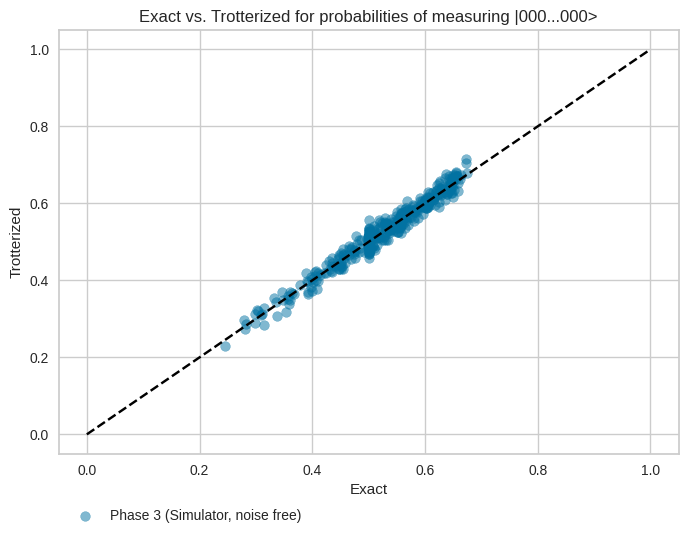

In [14]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_sim_noisy_extracted,
#     label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_nmit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu_name}, no mitigation)",
#     alpha=0.5,
# )
# plt.scatter(
#     probs_phase3_exact_extracted,
#     probs_phase3_mit_extracted,
#     label=f"Phase 3 (QPU: {backend_qpu_name}, with mitigation)",
#     alpha=0.5,
# )
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [15]:
data_exact_df = pd.read_json(f"{path}/data_exact_df.json")

In [16]:
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")

In [18]:
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")

FileNotFoundError: File ./data/2024-11-30T13:39Z/data_sim_noisy_df.json does not exist

In [16]:
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

FileNotFoundError: File ./data/2024-11-30T15:07Z/data_qpu_nmit_df.json does not exist

In [17]:
# For debugging
data_mit_df = data_exact_df

In [18]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

In [19]:
data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

In [ ]:
data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

In [ ]:
data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

In [21]:
print("Exact")
display(data_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.987920,-0.061658,0.952311,-0.119336,0.895021,-0.169341,0.819003,-0.208536,2.653082
1,1,1,0.998138,-0.036937,0.992566,-0.073563,0.983328,-0.109568,0.970496,-0.144650,0.865078
2,2,1,0.979901,-0.118091,0.921418,-0.225359,0.829791,-0.312150,0.713113,-0.371018,1.138950
3,3,1,0.990739,-0.034726,0.963232,-0.067608,0.918300,-0.096880,0.857279,-0.120938,4.367027
4,4,1,0.992402,0.086025,0.969841,0.169411,0.933008,0.247602,0.883028,0.318201,4.566077
...,...,...,...,...,...,...,...,...,...,...,...
75,75,1,0.991011,0.029347,0.964325,0.057164,0.920777,0.081994,0.861722,0.102524,4.398101
76,76,1,0.996290,0.009169,0.985197,0.018136,0.966825,0.026701,0.941353,0.034670,1.717613
77,77,1,0.998153,0.037745,0.992626,0.075180,0.983467,0.111996,0.970751,0.147894,1.843327
78,78,1,0.962672,-0.195226,0.856825,-0.362427,0.699622,-0.478893,0.515799,-0.531438,1.989057


In [22]:
print("Simulator (noise free)")
display(data_sim_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.989813,-0.064389,0.953728,-0.157233,0.891858,-0.175760,0.812061,-0.217544,2.653082
1,1,1,0.999184,-0.044874,0.989757,-0.105560,0.990183,-0.096230,0.961512,-0.145292,0.865078
2,2,1,0.985180,-0.109454,0.915599,-0.200127,0.843420,-0.302226,0.722925,-0.382609,1.138950
3,3,1,0.988905,-0.058990,0.956461,-0.067290,0.920381,-0.111793,0.846090,-0.112762,4.367027
4,4,1,0.992371,0.088498,0.965378,0.187253,0.932337,0.263882,0.896152,0.309533,4.566077
...,...,...,...,...,...,...,...,...,...,...,...
75,75,1,0.990418,0.022020,0.964642,0.077046,0.933938,0.117806,0.854046,0.101111,4.398101
76,76,1,0.995896,-0.018748,0.991503,0.010581,0.960505,0.036606,0.932292,0.056973,1.717613
77,77,1,0.993424,0.039678,0.998863,0.052731,0.981507,0.093326,0.953697,0.172854,1.843327
78,78,1,0.951543,-0.193926,0.862138,-0.345571,0.719902,-0.459992,0.475045,-0.553630,1.989057


In [21]:
print("Simulator (noisy)")
display(data_sim_noisy_df)

Simulator (noisy)


NameError: name 'data_sim_noisy_df' is not defined

In [ ]:
print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

## Exact

In [20]:
train_size = 0.8
session_id = 42

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(80, 11)"
4,Transformed data shape,"(80, 10)"
5,Transformed train set shape,"(64, 10)"
6,Transformed test set shape,"(16, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0059,0.0001,0.0082,0.9999,0.0034,0.0047,0.3460
huber,Huber Regressor,0.1036,0.0277,0.1385,0.9733,0.0509,0.0698,0.1880
rf,Random Forest Regressor,0.2685,0.1824,0.3680,0.8309,0.1223,0.1728,0.0500
et,Extra Trees Regressor,0.2685,0.2062,0.3964,0.8166,0.1269,0.1631,0.0400
gbr,Gradient Boosting Regressor,0.2846,0.2029,0.3964,0.8056,0.1309,0.1847,0.0170
ada,AdaBoost Regressor,0.3302,0.2112,0.4181,0.7998,0.1482,0.2385,0.0180
knn,K Neighbors Regressor,0.3740,0.2758,0.4737,0.7559,0.1568,0.2355,0.0160
lightgbm,Light Gradient Boosting Machine,0.4600,0.3580,0.5769,0.6918,0.1980,0.3224,0.3740
br,Bayesian Ridge,0.3918,0.3041,0.4793,0.6911,0.1849,0.2854,0.1920
par,Passive Aggressive Regressor,0.4602,0.3710,0.5554,0.6621,0.2090,0.3266,0.2030


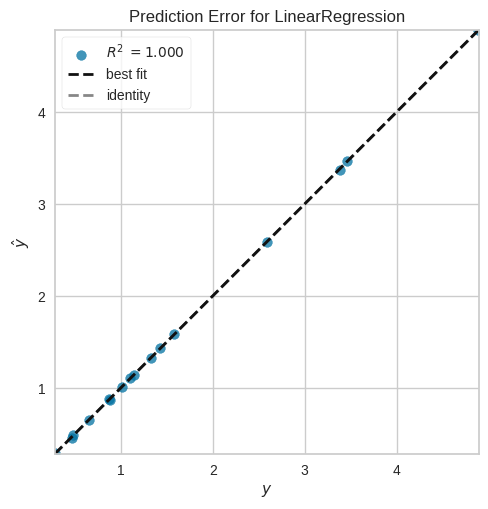

In [21]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_exact = s_exact.compare_models(turbo=True, sort="R2")

s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

In [ ]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim = s_sim.compare_models(turbo=True, sort="MSE")

s_sim.plot_model(best_sim, plot="error")

In [ ]:
manual_model_sim = s_sim.create_model("et")
s_sim.plot_model(manual_model_sim, plot="error")

## Trotter (Simulation, Noisy)

In [ ]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort="MSE")
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

In [ ]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_nmit = s_nmit.compare_models(turbo=True, sort="MSE")
s_nmit.plot_model(best_nmit, plot="error")

In [ ]:
manual_model_nmit = s_nmit.create_model("knn")
s_nmit.plot_model(manual_model_nmit, plot="error")

In [ ]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [ ]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_mit = s_mit.compare_models(turbo=True, sort="MSE")

In [ ]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

In [ ]:
s_mit.plot_model(best_mit, plot="error")

In [ ]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

In [ ]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")

In [ ]:
tuned_manual_model_mit = s_mit.tune_model(manual_model_mit, optimize="R2")
s_mit.plot_model(tuned_manual_model_mit, plot="error")